In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from FM.black_scholes import Black_Scholes
from SIM.GBM import simulate_GBM

In [12]:
class ML_American_Option:
    def __init__(self, S, K, T, r, sigma):
        self.S = S
        self.K = K
        self.T = T
        self.r = r
        self.sigma = sigma

    def price(self, n_simulations = 10000, n_steps = 50):
        dt = self.T / n_steps
        discount = np.exp(-self.r * dt)

        paths = np.zeros((n_simulations, n_steps + 1))
        paths[:, 0] = self.S
        for i in range(n_simulations):
            _, S_path = simulate_GBM(self.S, self.r, self.sigma, self.T, n_steps)
            paths[i, :] = S_path

        cash_flows = np.maximum(self.K - paths[:, -1], 0)

        for t in range(n_steps - 1, 0, -1):
            ST = paths[:, t]
            immediate_exercise = np.maximum(self.K - ST, 0)

            in_the_money = immediate_exercise > 0

            if not np.any(in_the_money):
                cash_flows *= discount
                continue

            X_train = ST[in_the_money].reshape(-1, 1)
            Y_train = cash_flows[in_the_money] * discount

            model = RandomForestRegressor(n_estimators = 10, max_depth = 5, random_state = 42)
            model.fit(X_train, Y_train)

            continuation_value = model.predict(X_train)

            exercise_decision = immediate_exercise[in_the_money] > continuation_value

            itm_indices = np.where(in_the_money)[0]

            cash_flows[itm_indices[exercise_decision]] = immediate_exercise[in_the_money][exercise_decision]

            cash_flows[itm_indices[~exercise_decision]] *= discount

            cash_flows[~in_the_money] *= discount

        return np.mean(cash_flows) * discount
    
am_ml = ML_American_Option(S=100, K=100, T=1, r=0.02, sigma=0.2)
ml_price = am_ml.price()
print(f"American Put Price (calculated via Random Forest LSM): ${ml_price:.2f}")

American Put Price (calculated via Random Forest LSM): $8.01


In [13]:
n_samples = 10000

S_data = np.random.uniform(50, 150, n_samples)
K_data = np.random.uniform(50, 150, n_samples)
T_data = np.random.uniform(0.1, 2.0, n_samples)     
r_data = np.random.uniform(0.01, 0.10, n_samples)   
sigma_data = np.random.uniform(0.1, 0.5, n_samples)

true_prices = []

In [14]:
for i in range(n_samples):
    bs = Black_Scholes(S_data[i], K_data[i], T_data[i], r_data[i], sigma_data[i])
    true_prices.append(bs.call_option_price())

df_bs = pd.DataFrame({
    'S': S_data,
    'K': K_data,
    'T': T_data,
    'r': r_data,
    'sigma': sigma_data,
    'True_Price': true_prices
})

print("Synthetic dataset Generated")

Synthetic dataset Generated


In [15]:
X = df_bs[['S', 'K', 'T', 'r', 'sigma']]
y = df_bs['True_Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

regr = RandomForestRegressor(n_estimators = 100, random_state = 42)
regr.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsample

In [16]:
y_pred = regr.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"Model Trained")
print(f"R2 Score: {r2}")
print(f"MSE: {mse}")

Model Trained
R2 Score: 0.9944614254760051
MSE: 3.386762064741149


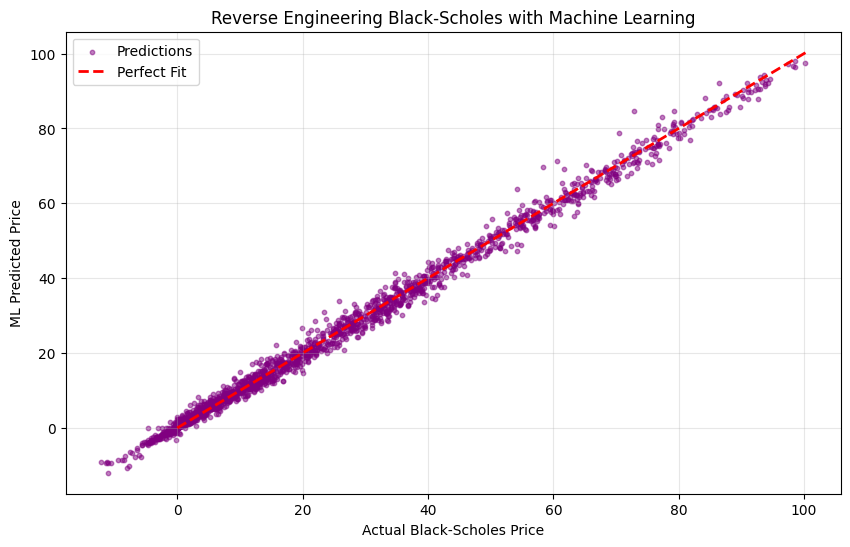

In [17]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, s=10, color='purple', label='Predictions')
plt.plot([0, max(y_test)], [0, max(y_test)], 'r--', lw=2, label='Perfect Fit')
plt.xlabel('Actual Black-Scholes Price')
plt.ylabel('ML Predicted Price')
plt.title('Reverse Engineering Black-Scholes with Machine Learning')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

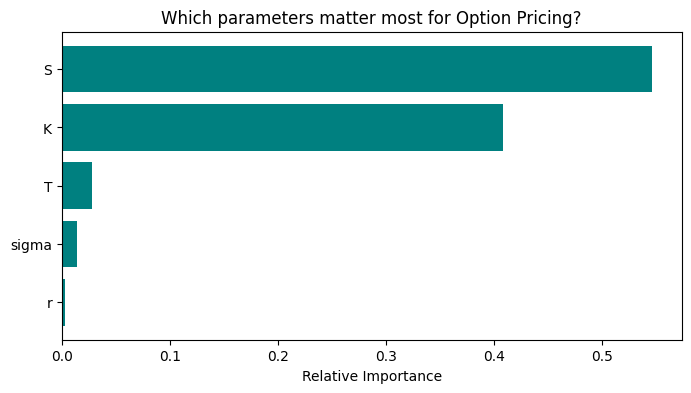

In [18]:
importances = regr.feature_importances_
features = X.columns
indices = np.argsort(importances)

plt.figure(figsize=(8, 4))
plt.barh(range(len(indices)), importances[indices], color='teal', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.title('Which parameters matter most for Option Pricing?')
plt.show()